# Лабораторная работа по Relevance Vector Regression
В рамках этой лабораторной работы необходимо:
- Имплементировать Relevance Vector Regression
- Применить на синетическом датасете (восстановление полинома), сравнить с Lasso из sklearn и гребневой регрессией
- Применить на данных sinc с RBF признаками, визуализировать "релевантные вектора", сравнить с Support Vector Regression и Lasso
- Сделать выводы

In [1]:
import numpy as np
import numpy.linalg as LA
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from __future__ import print_function

%matplotlib inline
np.random.seed(123)

def l2_error(X, t, w):
    return np.sum((X.dot(w.ravel()) - t) ** 2)

## Имплементация Relevance Vector Regression

Здесь необходимо реализовать четыре функции:

1. `get_w_sigma(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и возвращает параметры апостериорного распределения mu, sigma
2. `update_alpha_beta(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и делает один шаг итерационной процедуры для обновления гиперпараметров (было на лекции)
3. `fit_rvr(X, t, max_iters)`, которая принимает датасет (X, t) и максимальное количество итераций и возвращает обученные гиперпараметры и параметры апостериорного распределения на веса модели
4. `get_posterior_predictive(X, w, sigma, alpha, beta)`, которая принимает матрицу признаков X, параметры апостериорного распределения на веса (w, sigma), гиперпараметры RVR (alpha, beta) и вычисляет среднее и стандартное отклонение распределения $p(t | x, (X_{train}, t_{train}), \alpha, \beta)$ для предсказаний на новых точках из матрицы X

На что стоит обратить внимание:

1. Результаты дорогостоящих операций типа перемножения одних и тех же матриц нужно кешировать и переиспользовать
2. $\alpha$-ы для нерелевантных объектов должны принять значение `np.inf`, а соответствующие веса и их дисперсии должны иметь значение 0
3. Бесконечности и нули из предыдущего пункта должны обрабатываться корректно, без NaN-ов и warning-ов
4. Матрицу с бесконечными элементами на диагонали можно обращать более эффективно (достаточно обратить подматрицу)

Распределения:
* $p(t|x, w) = \mathcal{N}(t|x^Tw, \beta^{-1})$ - правдоподобие
* $p(w) = \mathcal{N}(w|0, A^{-1})$, где $A = diag(\alpha_1, \dots
\alpha_d)$ - prior
* $p(w|X, t) = \mathcal{N}(w|\mu, \Sigma)$, где $\Sigma = (\beta X^{T}X + A)^{-1}, \; \mu = w_{mp} = \beta \Sigma X^{T}t$ - апостериорное (было показано на лекции)

Размерности переменных:
$
\mathbb{R}: \beta \\
\mathbb{R}^d: x, w, \mu \\
\mathbb{R}^{d \times d}: A, \Sigma \\
\mathbb{R}^{n \times d}: X \\
\mathbb{R}^n: t
$

In [2]:
def get_w_sigma(X, t, alpha, beta):
    """Calculate the mean and the covariance matrix
       of the posterior distribution"""
    n, d = X.shape
    X_T = X.T
    mask = (np.diag(alpha) != np.inf)
    mask = np.ix_(mask, mask)
    sigma = np.zeros_like(alpha)
    sigma[mask] = LA.inv((beta * X_T @ X + alpha)[mask])
    w = beta * sigma @ X_T @ t
    return w, sigma

Формулы обновления гиперпараметров $(\alpha_1, \dots, \alpha_d, \beta)$:\
$$
\alpha_j^{new} = \frac{1 - \alpha_j^{old}\Sigma^{old}_{jj}}{(w_j^{old})^2}, \;
\beta^{new} = \frac{n - \sum\limits_{j=1}^{d}{(1 - \alpha_j^{old}\Sigma^{old}_{jj})}}{\|t - Xw^{old}\|^2}
$$
$$\Downarrow$$

$$
A^{new} = diag(\alpha_1^{new}, \dots, \alpha_d^{new}) \\
\Sigma^{new} = (\beta^{new} X^{T}X + A^{new})^{-1}, \; \mu^{new} = \beta^{new} \Sigma^{new} X^{T}t
$$


Формула обновления весов:
$$
w^{new} = w_{mp}(A^{new}, \beta^{new}) = \mu^{new}
$$

Итерационный процесс можно переписать следующим образом:
$$ 
\text{start}: A, \beta \\
\Sigma = (\beta X^{T}X + A)^{-1}, \; \mu = \beta \Sigma X^{T}t, \; w = \mu \\
z = 1 - A[diag] \times \Sigma[diag]\\
A[diag] = \frac{z}{w^2}, \; \beta = \frac{n - sum(z)}{\|t - Xw\|^2}
$$

In [3]:
def update_alpha_beta(X, t, alpha, beta):
    """Update the hyperperemeters to increase evidence"""
    w, sigma = get_w_sigma(X, t, alpha, beta)
    alpha_diag = np.diag(alpha).copy()
    mask = (alpha_diag != np.inf)
    z = 1 - alpha_diag[mask] * np.diag(sigma)[mask]    
    alpha_diag[mask] = z / (w[mask] ** 2)
    alpha_diag[alpha_diag > 1e+12] = np.inf
    alpha_new = np.diag(alpha_diag)
    beta_new = (n - sum(z)) / LA.norm(t - X @ w)
    return alpha_new, beta_new


def fit_rvr(X, t, max_iter=10000):
    """Train the Relevance Vector Regression model"""
    n, d = X.shape
    alpha = np.eye(d)
    beta = 1
    for i in tqdm(range(max_iter), desc='step'):
        alpha, beta = update_alpha_beta(X, t, alpha, beta)
    w, sigma = get_w_sigma(X, t, alpha, beta)
    return w, sigma, alpha, beta

Для матрицы признаков $X$, параметров апостериорного распределения на веса $(\mu, \Sigma)$ и гиперпараметров RVR$(A, \beta)$ найти распределение $p(t | x, (X_{train}, t_{train}), A, \beta)$ для прогнозирования целевой переменной $t$. Вычислить среднее и стандартное отклонение данного распределения. 

$$
p(t | X, (X_{train}, t_{train}), A, \beta) = 
\int p(t, w | X, (X_{train}, t_{train}), A, \beta)dw =
\int p(t | X, w, \beta)p(w | X_{train}, t_{train}, A)dw = 
\int \mathcal{N}(t|Xw, \beta^{-1}I)\mathcal{N}(w|\mu, \Sigma)dw
$$

Поскольку распределения сопряжены, интеграл берется аналитически, ровно как и интеграл-знаменатель в т.Байеса (обоснованность). 

Для определения параметров обратимся к одной из задач домашнего задания по матричным вычислениям:\
$
\left\{
  \begin{array}{l}
    p(x) = \mathcal{N}(x|\mu, \Sigma)\\
    p(y|x) = \mathcal{N}(y|Ax, \Gamma)\\
  \end{array}
\right. \Rightarrow p(y) = \mathcal{N}(y|A\mu, \Gamma + A\Sigma A^T)
$

Подставим $x = w, y = t, A = X, \Gamma = \beta^{-1}I$ и получим исходные распределения:
$
\left\{
  \begin{array}{l}
    p(w) = \mathcal{N}(w|\mu, \Sigma)\\
    p(t|X, w) = \mathcal{N}(t|Xw, \beta^{-1}I)\\
  \end{array}
\right. \Rightarrow p(t| X, (X_{train}, t_{train}), A, \beta) = \mathcal{N}(t|X\mu, \beta^{-1}I + X\Sigma X^T)
$

Значит, параметры данного распределения: 
* $X\mu$ - мат.ожидание
* $\beta^{-1}I + X\Sigma X^T$ - матрица ковариаций, значит ее диагональ - дисперсии

In [4]:
def get_posterior_predictive(X, w, sigma, alpha, beta):
    """" Compute the mean and the standard deviation
         of the posterior predictive distribution for inputs X"""
    n = X.shape[0]
    w = X @ w
    std = np.diag((1 / beta) * np.eye(n) + X @ sigma @ X.T)
    return w, std

## Восстановление полинома

Здесь решается модельная задача: зашумленным полиномом третьей степени сгенерированы данные для задачи регрессии. Нужно на этих данных обучить многочлен степени, не превышающей 20. Предлагается сравнить три модели: гребневую регрессию, L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных признаков.

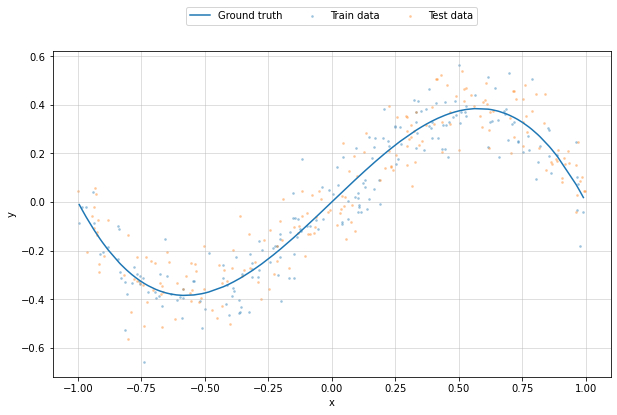

In [5]:
# Data generation

def gen_batch(n, w, beta):
    d = len(w)
    X = np.random.uniform(-1, 1, (n, 1))
    X = np.sort(X, axis=0)
    X = np.hstack([X ** i for i in range(d)])
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t

n = 200
d = 21
w_true = np.zeros(d)
w_true[1] = 1
w_true[3] = -1
beta_true = 100

X_train, t_train = gen_batch(n, w_true, beta_true)
X_test, t_test = gen_batch(n, w_true, beta_true)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

ax.grid(True, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [6]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)

step:   0%|          | 0/10000 [00:00<?, ?it/s]

In [7]:
predictive_mu, predictive_std = get_posterior_predictive(
    X_test,
    w_rvr,
    sigma_rvr,
    alpha_rvr,
    beta_rvr)

In [8]:
# Ridge Regression with Cross-Validation
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(cv=20, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False).fit(X_train, t_train)
w_ridge = ridge.coef_

In [9]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV, Lasso
lasso = LassoCV(cv=5, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False, max_iter=2000000).fit(X_train, t_train)
w_lasso = lasso.coef_

/home/anabatsh/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006909795579468803, tolerance: 0.0012854460800422096
  model = cd_fast.enet_coordinate_descent_gram(


Relevance Vector Regression
Features remaining: 423 / 21
Train error: 0.00904631739896042
Test error:  0.009835849242806971
--------------------------------------------------
Ridge Regression
Features remaining: NA (no sparsity)
Train error: 0.00909503455322363
Test error:  0.009961442053083665
--------------------------------------------------
Lasso Regression
Features remaining: 9 / 21
Train error: 0.008878963547469506
Test error:  0.010139505424318334


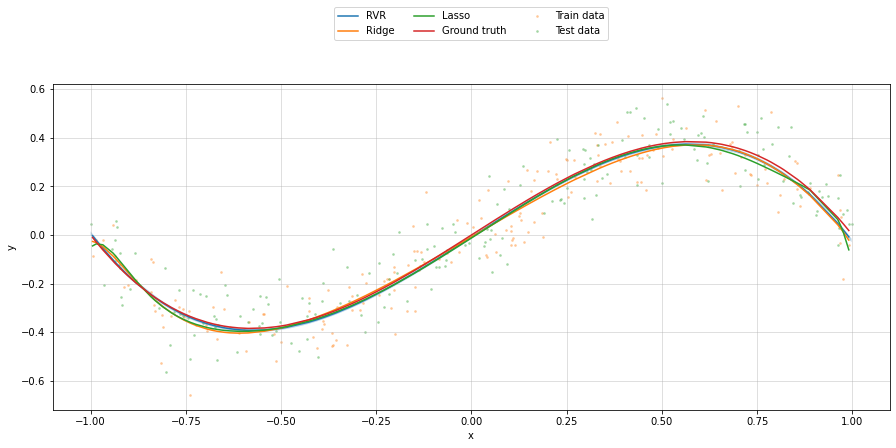

In [10]:
# Comparison
print('Relevance Vector Regression')
print('Features remaining:', np.sum(alpha_rvr < 1e8), '/', d)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Ridge Regression')
print('Features remaining: NA (no sparsity)')
print('Train error:', l2_error(X_train, t_train, w_ridge) / n)
print('Test error: ', l2_error(X_test, t_test, w_ridge) / n)
print('-'*50)
print('Lasso Regression')
print('Features remaining:', np.sum(np.abs(w_lasso) > 1e-20), '/', d)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)

fig, ax = plt.subplots(figsize=(15, 6))
ax.fill_between(X_test[:, 1],
                predictive_mu - predictive_std,
                predictive_mu + predictive_std,
                alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_rvr), label='RVR')
ax.plot(X_train[:, 1], X_train.dot(w_ridge), label='Ridge')
ax.plot(X_train[:, 1], X_train.dot(w_lasso), label='Lasso')
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)


ax.grid(True, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

Как видно, метод релевантных векторов весьма неплохо справляется со своей задачей: синяя кривая ближе всех остальных к красной (истинная зависимость). Поэтому метод релевантных векторов в данной задаче - самый лучшие вариант решения.

## Регрессия с RBF-признаками

Здесь решается другая модельная задача: необходимо восстановить зашумленную функцию `sinc(x)`. Предлагается применить kernel trick с RBF-ядром (можно использовать функцию `sklearn.metrics.pairwise.rbf_kernel`), обучить три модели: SVM-регрессию (SVR), L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных опорных / релевантных объектов.

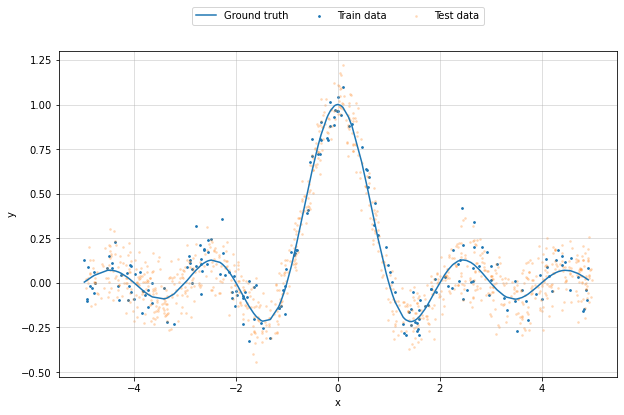

In [11]:
# Data generation
from sklearn.metrics.pairwise import rbf_kernel

def gen_batch(n, beta):
    points = np.random.uniform(-5, 5, n)
    points = np.sort(points)
    t = np.sinc(points) + np.random.normal(size=n) / beta ** 0.5
    return points, t

n = 200
n_test = 1000
d = n + 1
beta_true = 100

points_train, t_train = gen_batch(n, beta_true)
points_test, t_test = gen_batch(n_test, beta_true)


# RBF-transform
X_train_old = points_train.reshape(-1, 1)
X_test_old = points_test.reshape(-1, 1)

X_train = rbf_kernel(X_train_old)
X_test = rbf_kernel(X_test_old, X_train_old)

# # Constant feature
X_train = np.hstack((np.ones((n, 1)), X_train))
X_test = np.hstack((np.ones((n_test, 1)), X_test))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=1)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.2)
ax.plot(points_train, np.sinc(points_train), label='Ground truth')

ax.grid(True, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [12]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)

step:   0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
predictive_mu, predictive_std = get_posterior_predictive(
    X_test,
    w_rvr,
    sigma_rvr,
    alpha_rvr,
    beta_rvr)

In [14]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=10, alphas=10.**np.linspace(-5, 1, 20),
                fit_intercept=False, max_iter=100000, tol=1e-2, n_jobs=10).fit(X_train, t_train)
w_lasso = lasso.coef_

In [15]:
# Support Vector Regression
from sklearn.svm import SVR
svr = SVR(gamma=1, tol=1e-6, C=1).fit(points_train.reshape(-1, 1), t_train)

Relevance Vector Regression
Objects remaining: 40008 / 200
Train error: 0.007971492818814587
Test error:  0.05412914882873936
--------------------------------------------------
Lasso Regression
Objects remaining: 63 / 200
Train error: 0.00944793599324124
Test error:  0.05705374505061664
--------------------------------------------------
Support Vector Regression
Objects remaining: 59 / 200
Train error: 0.008025457213352068
Test error:  0.05380997349742385


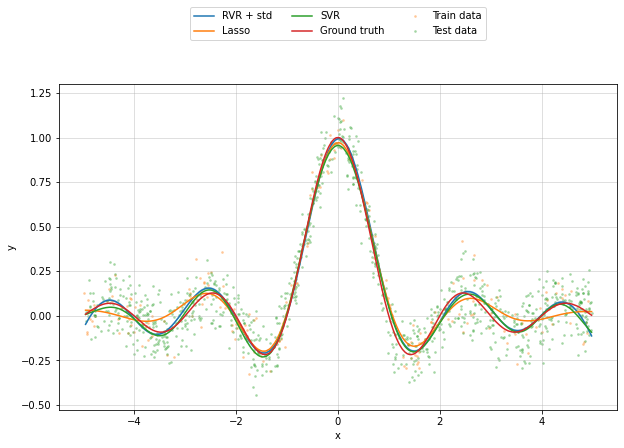

In [16]:
# Comparison
print('Relevance Vector Regression')
print('Objects remaining:', np.sum(alpha_rvr[1:] < 1e8), '/', n)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Lasso Regression')
print('Objects remaining:', np.sum(np.abs(w_lasso[1:]) > 1e-20), '/', n)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)
print('-'*50)
print('Support Vector Regression')
print('Objects remaining:', len(svr.support_), '/', n)
print('Train error:', np.sum((svr.predict(points_train.reshape(-1, 1)) - t_train) ** 2) / n)
print('Test error: ', np.sum((svr.predict(points_test.reshape(-1, 1)) - t_test) ** 2) / n)

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(points_test,
                predictive_mu - predictive_std,
                predictive_mu + predictive_std, alpha=0.3)
ax.plot(points_test, X_test.dot(w_rvr), label='RVR + std')
ax.plot(points_test, X_test.dot(w_lasso), label='Lasso')
ax.plot(points_test, svr.predict(points_test.reshape(-1, 1)), label='SVR')
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)


ax.grid(True, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

И в данном случае RVR показал себя хорошо. Хотя трудно сказать, является ли он лучшим решением: кривая лассо весьма похожа по качеству, если судить по графику. Хотя похоже, что и тут он победил остальных. 

### Визуализация релевантных объектов для RVR

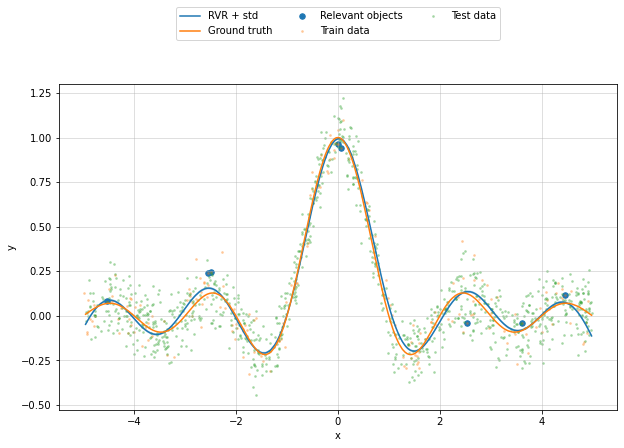

In [17]:
relevant = np.diag(alpha_rvr)[1:] < 1e8
fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(points_test,
                predictive_mu - predictive_std,
                predictive_mu + predictive_std, alpha=0.3)
ax.plot(points_test, X_test.dot(w_rvr), label='RVR + std')
ax.scatter(points_train[relevant], t_train[relevant], c='tab:blue', s=30, label='Relevant objects')
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)

ax.grid(True, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

Неудивительно, что основными объектами оказались точки перегибов. Уже исходя из них можно представить примерный вид зависимости. 

## Выводы

Метод релевантных векторов хорошо показал себя в данных задачах. Способоность автоматически фильтровать признаки позволила не переобучаться на шуме (метод не обращал внимания на зашумленность данных и сохранил обобщающую способность - т.е. восстанавливал общую зависимость) и выделять самые важные признаки. 